# ドル円為替レート 週足, Parabolic SAR

In [1]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

symbol = 'USDJPY=X'
#symbol = 'USDJPY=X'
ticker = yf.Ticker(symbol)
df = ticker.history(period='2y', interval='1wk')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-02-06 00:00:00+00:00,132.009003,132.891998,129.834000,131.410004,0,0.0,0.0
2023-02-13 00:00:00+00:00,131.550995,135.080002,131.466003,134.110001,0,0.0,0.0
2023-02-20 00:00:00+00:00,134.307007,136.470001,133.929001,136.470001,0,0.0,0.0
2023-02-27 00:00:00+00:00,136.395004,137.065002,135.259995,135.839996,0,0.0,0.0
2023-03-06 00:00:00+00:00,135.869995,137.895996,134.171997,135.000000,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-01-06 00:00:00+00:00,157.481003,158.856995,156.274002,157.690002,0,0.0,0.0
2025-01-13 00:00:00+00:00,157.886993,158.121994,154.983002,156.270004,0,0.0,0.0
2025-01-20 00:00:00+00:00,156.306000,156.746994,154.798004,155.979996,0,0.0,0.0


## パラボリック SAR

In [2]:
def psar(ohlc: pd.DataFrame, iaf: float = 0.02, maxaf: float = 0.2) -> dict:
    length = len(ohlc)
    high = ohlc['High'].tolist()
    low = ohlc['Low'].tolist()
    close = ohlc['Close'].tolist()
 
    psar = close[0:len(close)]
    psarbull = [None] * length
    psarbear = [None] * length
 
    bull = True
    af = iaf
    ep = low[0]
    price_high = high[0]
    price_low = low[0]
 
    for i in range(2, length):
        if bull:
            psar[i] = psar[i - 1] + af * (price_high - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (price_low - psar[i - 1])
        reverse = False
 
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = price_high
                price_low = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = price_low
                price_high = high[i]
                af = iaf
 
        if not reverse:
            if bull:
                if high[i] > price_high:
                    price_high = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < price_low:
                    price_low = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
 
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
 
    return {
        'bear': np.array(psarbear, dtype='float64'),
        'bull': np.array(psarbull, dtype='float64'),
    }

## 週足チャートとパラボリック SAR

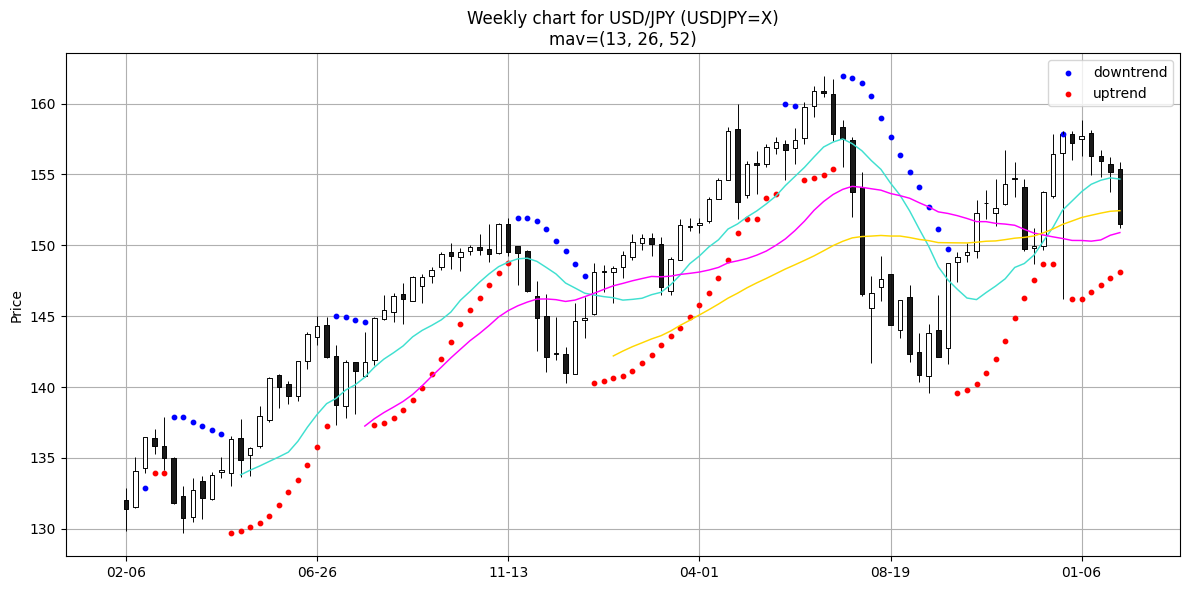

In [3]:
dict_psar = psar(df)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=10,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=10,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(13, 26, 52),
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)
try:
    ax.set_title('Weekly chart for %s (%s)\nmav=(13, 26, 52)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Weekly chart for %s\nmav=(13, 26, 52)' % symbol)

ax.grid()

plt.tight_layout()
plt.savefig('weekly_chart_exchange_psar.png')
plt.show()

In [4]:
df.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-02-03 00:00:00+00:00,155.363007,155.863998,152.108994,152.628998,0,0.0,0.0


In [5]:
df.tail(2)['Close']

Date
2025-01-27 00:00:00+00:00    155.190002
2025-02-03 00:00:00+00:00    152.628998
Name: Close, dtype: float64

In [6]:
df.tail(2)['Close'].diff()

Date
2025-01-27 00:00:00+00:00         NaN
2025-02-03 00:00:00+00:00   -2.561005
Name: Close, dtype: float64

In [7]:
df['Close'].rolling(26).mean().tail(5)

Date
2025-01-06 00:00:00+00:00    150.337692
2025-01-13 00:00:00+00:00    150.291154
2025-01-20 00:00:00+00:00    150.377693
2025-01-27 00:00:00+00:00    150.708846
2025-02-03 00:00:00+00:00    150.938462
Name: Close, dtype: float64

In [8]:
df['Close'].rolling(52).mean().tail(5)

Date
2025-01-06 00:00:00+00:00    151.961711
2025-01-13 00:00:00+00:00    152.118153
2025-01-20 00:00:00+00:00    152.268154
2025-01-27 00:00:00+00:00    152.399308
2025-02-03 00:00:00+00:00    152.462750
Name: Close, dtype: float64